## Carga y Slicing de Datos

In [1]:
import numpy as np 
import seaborn as sns
import sklearn as skl
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.animation import FuncAnimation

# Utiliza el estilo de gráficos de Seaborn incluso cuando se utiliza Matplotlib
sns.set()

# Se cargan los datos sobre predicción de precios de casas
Data = np.load('proyecto_training_data.npy')

# Dimensiones de los datos
filas, cols = Data.shape

# Límite para extraer los datos de entrenamiento (80%)
lim_sup_train = int(filas*0.8)

# Extracción de datos de entrenamiento (80%) y de validación (20%)
train_data = Data[0:lim_sup_train, :]
test_data = Data[lim_sup_train:filas, :]


## Análisis Exploratorio de los Datos

Cálculo de la media, valor máximo, valor mínimo, rango y desviación estándar de tanto X como Y.

In [2]:
# Medias para cada variable en el dataset 
# (nanmean ignora valores NaN)
medias = np.nanmean(Data, axis=0)

# Valor máximo y mínimo de cada variable
val_max = np.nanmax(Data, axis=0)
val_min = np.nanmin(Data, axis=0)

# Rango "pico a pico" de cada variable
rango = val_max - val_min

# Desviación estándar de cada variable
desvest = np.nanstd(Data, axis=0)

# Utilizado para evitar que Numpy utilice notación científica
np.set_printoptions(precision=3, suppress=True)

print("Medias:", np.around(medias, decimals=2))
print("Max:", val_max)
print("Min:", val_min)
print("Rango:", rango)
print("Desviación Est:", desvest)

Medias: [180921.2       6.1    1162.63      6.52   1971.27     70.05]
Max: [755000.     10.   4692.     14.   2010.    313.]
Min: [34900.     1.   334.     2.  1872.    21.]
Rango: [720100.      9.   4358.     12.    138.    292.]
Desviación Est: [79415.292     1.383   386.455     1.625    30.193    24.275]


Para cada variable en el dataset usar seaborn para graficar un histograma de la variable.

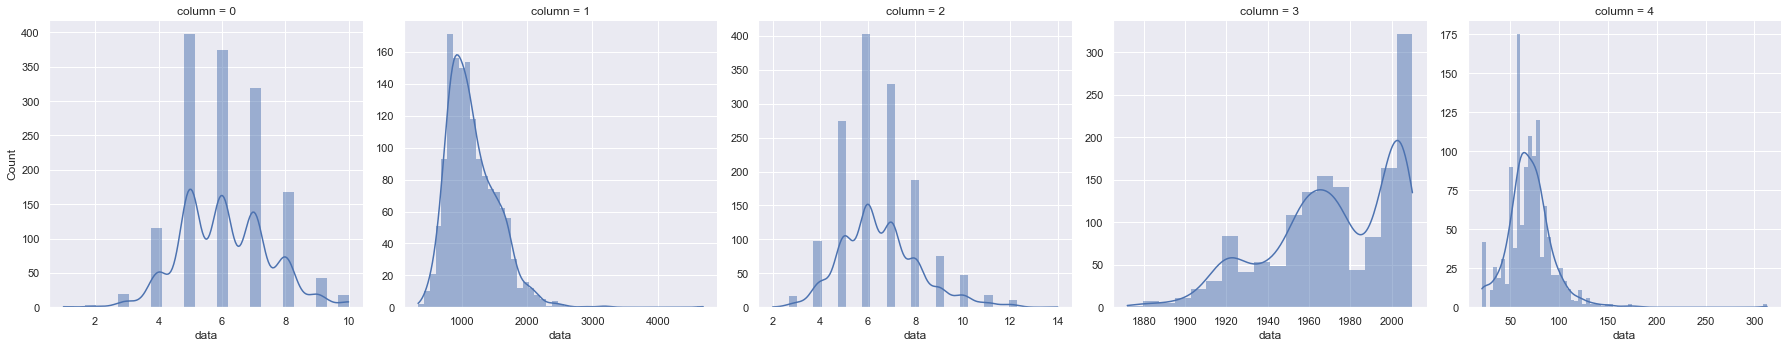

In [3]:
sns.set_theme()

# Variables independientes del dataset
VariablesInd = Data[:, 1:6]

# Aplana las 5 columnas de datos
FlatData = VariablesInd.flatten(order='F')

# Se crea un vector con números de 0 al número de columnas menos 1
#       Código: np.arange(VariablesInd.shape[1])
# Se repite cada número en el vector "para abajo" el número de filas
#       Código: np.repeat(num_cols, VariablesInd.shape[0])
Columns = np.repeat(np.arange(VariablesInd.shape[1]), VariablesInd.shape[0])

# Se crea un dataframe de pandas temporal
df = pd.DataFrame({"data": FlatData, "column": Columns})

# Creación del displot
# "sharey" es necesario para que no se compartan las escalas Y entre subplots
# "common_bins" es necesario para que no se compartan las escalas X entre subplots
g = sns.displot(data=df, 
                x="data", col="column", 
                kde=True, 
                facet_kws={"sharey": False, "sharex": False},
                common_bins=False)


## Correlación y Gráfica de X y Y

Gráfica de los puntos X y Y utilizando un scatter plot, además de la presentación del coeficiente de correlación entre ambas variables

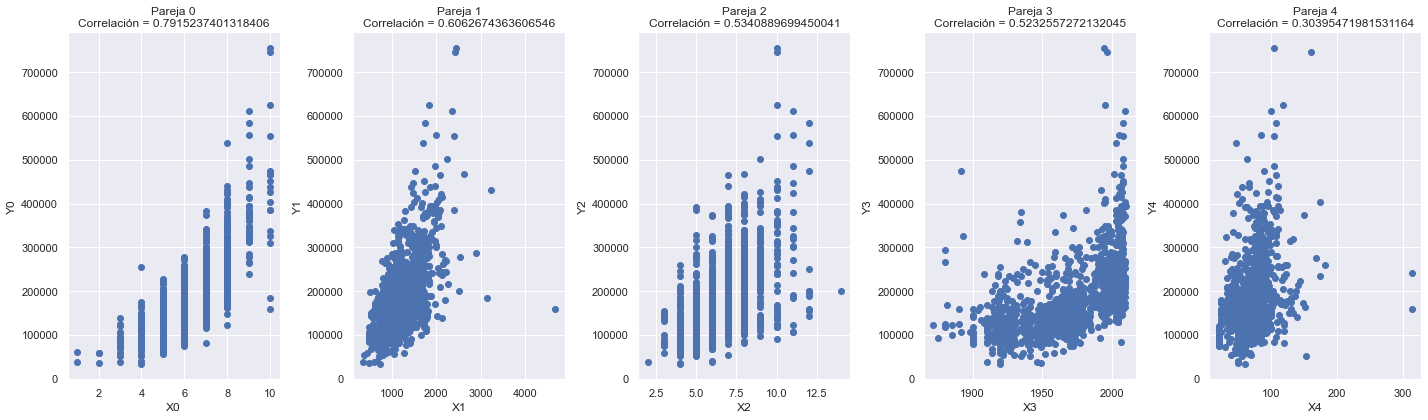

In [4]:
# Correlación de Pearson
def corr_pearson(X,Y):

    # Media de X y Y (Cada serie de valores es una columna nueva)
    MediaX = np.nanmean(X, axis=0)
    MediaY = np.nanmean(Y, axis=0)

    # Cálculo de la covarianza
    Numerador = np.nansum((X - MediaX)*(Y - MediaY), axis=0)
    Covarianza = Numerador / (X.shape[0] - 1)

    return Covarianza / (np.nanstd(X, axis=0) * np.nanstd(Y, axis=0))

X = Data[:,1:6]
Y = Data[:,0]

fig, axes = plt.subplots(1,5)
fig.set_size_inches(20,6)

for i in range(5):
    axes[i].scatter(X[:,i], Y)
    axes[i].set_xlabel(f"X{i}")
    axes[i].set_ylabel(f"Y{i}")
    axes[i].title.set_text(f"Pareja {i}\nCorrelación = {corr_pearson(X[:,i], Y)}")

# Para prevenir gráficas sobre-puestas
fig.tight_layout()


De acuerdo con lo observado en las gráficas y los coeficientes de correlación obtenidos, se podría llegar a establecer que la pareja que presenta mayor "potencial predictivo" utilizando un modelo lineal es la pareja 0 o aquella que corresponde a las primeras dos columnas de los datos cargados. 

## Función para Modelo de Regresión Lineal

Función para entrenar un modelo de regresión lineal de una variable con la forma y = mx + b

In [48]:
def train_linreg(X, Y, epochs=200, imprimir_error_cada=10, lr=0.001):

    # Se redimensionan los arrays para convertirlos en vectores columna
    X = np.reshape(X, (len(X), 1))
    Y = np.reshape(Y, (len(Y), 1))

    # Se cambia el tipo de datos para evitar errores de overflow
    X = X.astype('float32')
    Y = Y.astype('float32')

    # Se le agrega una columna de unos
    X = np.append(X, np.ones(X.shape), axis=1)

    # Se inicializan los parámetros "m" y "b"
    # Se crea un vector fila para los parametros (Vector de 2X1)
    m = 0
    b = 0
    params = np.array([m, b])
    params = np.reshape(params, (len(params), 1))

    # Se almacena el primer modelo en un diccionario
    modelo = {}
    modelo[0] = params

    # Historial del error obtenido por epoch
    error_historial = np.zeros((epochs,1))

    # Código para las epochs
    for i in range(epochs):

        # Cálculo de yhat o la estimación de los valores de y
        yhat = np.dot(X, params)

        # Cálculo del error entre "y" y "yhat"
        error = np.nanmean((Y - yhat)**2) / 2

        # Se guarda el error actual en el historial
        error_historial[i] = error

        # Cálculo del gradiente del error con respecto a cada parámetro
        #   Elemento 0: Gradiente de m
        #   Elemento 1: Gradiente de b
        grad = np.nanmean((yhat - Y) * X, axis=0)
        grad = np.reshape(grad, (len(grad), 1))

        # Actualización de los parámetros del modelo
        params = params - lr * grad

        # Almacenamiento del modelo en la iteración actual en un diccionario
        modelo[i+1] = params


    return modelo, error_historial


Función que permita visualizar como cambia el error en el tiempo. Esta debe tomar como parámetro el vector de errores generados durante el entrenamiento y graficar en el eje "X" el número de iteración y en el eje "Y" el error para esa iteración

In [49]:
def visualizar_error(error):
    
    # Vector con el número de iteraciones (array que incrementa de 1 en 1)
    Iteraciones = np.arange(1, len(error)+1, 1)
    
    # Se grafica el desarrollo del error
    plt.plot(Iteraciones, error, linewidth=3)
    plt.xlabel("Iteraciones")
    plt.ylabel("Error")
    plt.title("Evolución del Error")

    return None

# =======================================
# Uso de la función 
# =======================================

X = Data[:,5]
Y = Data[:,0]

modelo, error = train_linreg(X,Y)
visualizar_error(error)
plt.show()


Función que permita visualizar como evoluciona el modelo entrenado en el tiempo. La función tomará la estructura de datos conteniendo el historial de modelos y un valor "n" que indica cada cuantas iteraciones se grafica el modelo resultante.

In [17]:
# Gráficas que cambian durante la animación
def animation_frame(i, modelo, x_model, line):
    
    # El plot puede continuar corriendo y se resetea al reiniciar
    if i == 0:
        y_model = 0*x_model + 0
        line.set_data(x_model, y_model)
        return line,

    # Parámetros del modelo de la iteración "i" actual
    params = modelo[i]
    m = params[0]
    b = params[1]

    # Cálculo de las "y's" correspondientes a la recta
    y_model = m * x_model + b
    
    # Se actualiza la recta
    line.set_ydata(y_model)

    return line, 

# Animación para visualizar la evolución de la recta acoplada
def visualizar_modelo(X,Y,modelo):

    %matplotlib ipympl

    fig, ax = plt.subplots()

    # Setup de las variables "globales" de la clase
    x_model = np.linspace(min(X), max(X), 1000)
    y_model = 0*x_model + 0

    # Setup del plot con el modelo
    line, = ax.plot(x_model, y_model, 'r')

    # Gráfica de los puntos con los datos (estática)
    ax.scatter(X,Y)
    ax.set_xlabel("X (Variable Independiente)")
    ax.set_ylabel("Precio")
    ax.set_title("Evolución de Modelo")

    anim = FuncAnimation(fig, func=animation_frame, frames=len(modelo), 
                        interval=10, repeat=False, blit=True, fargs=(modelo, x_model, line))

    return anim


# =======================================
# Uso de la función 
# =======================================

X = Data[:,1]
Y = Data[:,0]
modelo, error = train_linreg(X,Y)
animacion = visualizar_modelo(X, Y, modelo)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Claramente, esto no consiste de exactamente lo que se solicitaba en la guía de trabajo, ya que no grafica un cierto número de rectas en el mismo plot (algo  más sencillo de hacer). Sin embargo, considero que esta implementación resulta mucho más ordenada y comprensible en términos de su presentación. Debido a esto, obvié el parámetro "n" ya que ya no existe la necesidad de incluirlo.

## Entrenamiento de Modelos de Regresión Lineal

Utilizar las funciones previas para entrenar modelos de regresión lineal (y = mx + b) para cada una de las variables "X" elegidas. Basándose en las funciones para graficar creadas previamente, elegir el número de "epochs". 

### Variable 0: Overall Quality

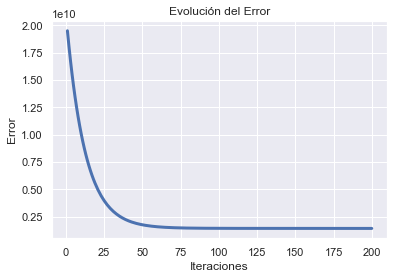

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [27]:
# Siempre colocar esta línea al inicio para que ambas gráficas se generen
%matplotlib inline

# Extracción de los datos
X = Data[:,1]
Y = Data[:,0]

# Generación de modelo
modelo, error = train_linreg(X,Y)

# Visualización de error
plt.clf()
visualizar_error(error)
plt.show()

# Visualización de modelo
animacion = visualizar_modelo(X, Y, modelo)

### Variable 1: Pies Cuadrados del Primer Piso

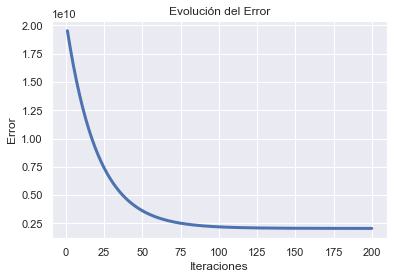

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [42]:
# Siempre colocar esta línea al inicio para que ambas gráficas se generen
%matplotlib inline

# Extracción de los datos
# Se escalan los valores en el eje X para evitar errores de overflow
X = Data[:,2] / 1000
Y = Data[:,0]

# Generación de modelo
modelo, error = train_linreg(X,Y, lr = 0.01)

# Visualización de error
plt.clf()
visualizar_error(error)
plt.show()

# Visualización de modelo
animacion = visualizar_modelo(X, Y, modelo)

### Variable 2: Número total de Cuartos

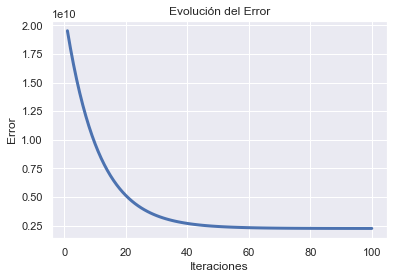

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
# Siempre colocar esta línea al inicio para que ambas gráficas se generen
%matplotlib inline

# Extracción de los datos
X = Data[:,3]
Y = Data[:,0]

# Generación de modelo
modelo, error = train_linreg(X,Y, epochs=100)

# Visualización de error
plt.clf()
visualizar_error(error)
plt.show()

# Visualización de modelo
animacion = visualizar_modelo(X, Y, modelo)

### Variable 3: Fecha de la Construcción

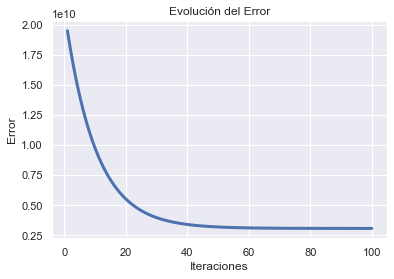

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [44]:
# Siempre colocar esta línea al inicio para que ambas gráficas se generen
%matplotlib inline

# Extracción de los datos
# Se escala el eje X para evitar errores de overflow
X = Data[:,4] / 1000
Y = Data[:,0]

# Generación de modelo
modelo, error = train_linreg(X,Y, lr=0.01, epochs=100)

# Visualización de error
plt.clf()
visualizar_error(error)
plt.show()

# Visualización de modelo
animacion = visualizar_modelo(X, Y, modelo)

### Variable 4: Pies Lineales Conectados a la Propiedad

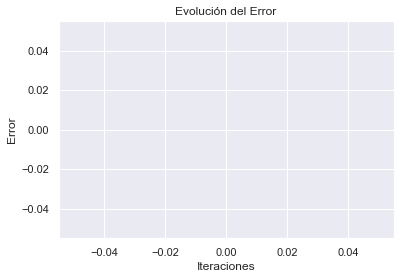

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
# Siempre colocar esta línea al inicio para que ambas gráficas se generen
%matplotlib inline

# Extracción de los datos
# Se escala el eje X para evitar errores de overflow
X = Data[:,5] / 10
Y = Data[:,0]

# Generación de modelo
modelo, error = train_linreg(X,Y)

# Visualización de error
plt.clf()
visualizar_error(error)
plt.show()

# Visualización de modelo
animacion = visualizar_modelo(X, Y, modelo)